In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import pandas as pd
import librosa
from tqdm import tqdm_notebook as tqdm
import pickle
import IPython.display as ipd
import librosa.display
from catboost import CatBoostClassifier
from catboost import Pool
from sklearn import svm
from sklearn.linear_model import LogisticRegression
%matplotlib inline

Using TensorFlow backend.


## Chroma

In [2]:
data = pd.read_pickle("../Data/Piano/data-piano-xl.pkl")

In [3]:
data["Chroma"] = data["Note"].apply(lambda x: x[:-1])

In [4]:
data["Chroma"].unique()

array(['C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B', 'C'],
      dtype=object)

In [5]:
data["Chroma"] = data["Chroma"].apply(lambda x: librosa.note_to_midi(x + "0") - 12)

In [6]:
data["Chroma"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0], dtype=int64)

In [7]:
def create_xy(df, target_column):
    return df.drop(target_column, axis=1), df[target_column]

def split_data(df, target_column):
    X_train, y_train = create_xy(df.sample(round(0.8*df.shape[0])), target_column)
    df = df.drop(X_train.index)
    X_val, y_val = create_xy(df.sample(round(0.5*df.shape[0])), target_column)
    df = df.drop(X_val.index)
    X_test, y_test = create_xy(df, target_column)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [8]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(data.drop(["Piano", "Note"], axis=1), "Chroma")

In [9]:
chroma_model = keras.Sequential([
    keras.layers.Dense(256, input_shape=(16000,)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(12, activation=tf.nn.softmax)
])
chroma_model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
chroma_model.fit(X_train, y_train, epochs=10, verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
 - 6s - loss: 1.6339 - acc: 0.6925
Epoch 2/10
 - 5s - loss: 0.8516 - acc: 0.9377
Epoch 3/10
 - 5s - loss: 0.6492 - acc: 0.9595
Epoch 4/10
 - 5s - loss: 0.4777 - acc: 0.9785
Epoch 5/10
 - 5s - loss: 0.3756 - acc: 0.9866
Epoch 6/10
 - 5s - loss: 0.3636 - acc: 0.9845
Epoch 7/10
 - 5s - loss: 0.2710 - acc: 0.9916
Epoch 8/10
 - 5s - loss: 0.2368 - acc: 0.9916
Epoch 9/10
 - 5s - loss: 0.2495 - acc: 0.9873
Epoch 10/10
 - 5s - loss: 0.3055 - acc: 0.9803


In [11]:
val_loss, val_acc = chroma_model.evaluate(X_val, y_val)
val_acc

308/308 [==============================] - ETA:  - ETA:  - 0s 319us/step


0.9740259732518878

## Octave

In [8]:
data["Octave"] = data["Note"].apply(lambda x: int(x[-1]) - 3)

In [9]:
data["Octave"].unique()

array([0, 1, 2], dtype=int64)

### NN

In [14]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(data.drop(["Piano", "Note"], axis=1), "Octave")

In [15]:
octave_model = keras.Sequential([
    keras.layers.Dense(256, input_shape=(16000,)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(3, activation=tf.nn.softmax)
])
octave_model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
octave_model.fit(X_train.drop("Chroma", axis=1), y_train, epochs=10, verbose=2)

Epoch 1/10
 - 6s - loss: 0.8467 - acc: 0.6189
Epoch 2/10
 - 5s - loss: 0.5496 - acc: 0.8033
Epoch 3/10
 - 5s - loss: 0.4464 - acc: 0.8600
Epoch 4/10
 - 5s - loss: 0.3673 - acc: 0.9068
Epoch 5/10
 - 5s - loss: 0.3295 - acc: 0.9156
Epoch 6/10
 - 5s - loss: 0.3606 - acc: 0.9205
Epoch 7/10
 - 5s - loss: 0.2908 - acc: 0.9317
Epoch 8/10
 - 5s - loss: 0.2722 - acc: 0.9384
Epoch 9/10
 - 5s - loss: 0.2373 - acc: 0.9472
Epoch 10/10
 - 5s - loss: 0.1822 - acc: 0.9595


In [17]:
val_loss, val_acc = octave_model.evaluate(X_val.drop("Chroma", axis=1), y_val)
val_acc

313/313 [==============================] - ETA:  - ETA:  - 0s 324us/step


0.8881789120241476

In [18]:
predictions = np.argmax(octave_model.predict(X_val.drop("Chroma", axis=1)), axis=1)
index_misclass = predictions != y_val

In [19]:
for i,j,k in zip(X_val[index_misclass]["Chroma"], predictions[index_misclass], y_val[index_misclass]):
    print(i,j,k)

0 2 1
10 1 2
3 2 1
2 1 0
3 2 1
0 1 2
3 2 1
7 2 1
5 1 0
8 1 0
10 0 1
10 2 1
6 0 1
7 2 1
2 1 2
10 0 1
6 0 1
3 1 0
2 1 2
8 1 2
6 2 1
10 0 1
3 2 0
6 1 2
11 1 2
2 0 1
8 1 2
6 0 1
6 0 1
3 1 0
5 2 1
9 1 0
2 2 1
1 2 0
4 1 0


### Catboost

In [20]:
train_dataset = Pool(data=X_train.drop("Chroma", axis=1),
                     label=y_train)
eval_dataset = Pool(data=X_val.drop("Chroma", axis=1),
                    label=y_val)
model = CatBoostClassifier(iterations=3000, # 1000-2000
                           learning_rate=0.01, # 0.05
                           depth=8, # 8
                           loss_function='MultiClass', 
                           task_type="GPU")

In [ ]:
model.fit(train_dataset)

0:	learn: -1.0956680	total: 975ms	remaining: 48m 42s
1:	learn: -1.0922848	total: 1.72s	remaining: 42m 57s
2:	learn: -1.0890032	total: 2.47s	remaining: 41m 6s
3:	learn: -1.0862261	total: 3.26s	remaining: 40m 38s
4:	learn: -1.0837173	total: 4s	remaining: 39m 57s
5:	learn: -1.0805922	total: 4.73s	remaining: 39m 20s
6:	learn: -1.0778972	total: 5.52s	remaining: 39m 21s
7:	learn: -1.0751425	total: 6.33s	remaining: 39m 26s
8:	learn: -1.0723746	total: 7.11s	remaining: 39m 23s
9:	learn: -1.0699865	total: 7.83s	remaining: 39m 2s
10:	learn: -1.0673568	total: 8.61s	remaining: 38m 58s
11:	learn: -1.0648717	total: 9.35s	remaining: 38m 47s
12:	learn: -1.0621266	total: 10.1s	remaining: 38m 33s


In [53]:
preds_class = model.predict(eval_dataset)
preds_class = preds_class.reshape((preds_class.shape[0],))

In [54]:
(preds_class == y_val).mean()

0.8993506493506493

In [56]:
cat_misclass = (preds_class != y_val)

In [69]:
misclass = cat_misclass | svm_misclass | index_misclass

In [71]:
for i,j,k,l,m in zip(X_val[misclass]["Chroma"], preds_class[misclass], 
                   predictions[misclass], svm_pred[misclass], y_val[misclass]):
    print("{:>8} {:>8} {:>8} {:>8} {:>8}".format(i,j,k,l,m))

       9      1.0        1        2        1
       5      2.0        1        1        1
       4      1.0        0        1        1
       9      1.0        1        2        1
       4      1.0        1        2        1
      10      1.0        0        2        0
       0      1.0        1        2        1
      11      1.0        0        2        0
       7      0.0        0        2        0
       9      0.0        2        2        0
      11      0.0        0        2        0
      10      1.0        1        2        1
       5      1.0        1        2        1
       8      1.0        1        2        1
       3      2.0        1        2        2
       8      1.0        0        2        2
       2      1.0        1        0        0
       3      2.0        1        2        2
       8      1.0        1        2        1
       1      0.0        1        1        0
       8      1.0        1        2        1
       6      1.0        1        2        1
       1  

### SVM

In [10]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(data.drop(["Piano", "Note", "Chroma"], axis=1), "Octave")

In [14]:
clf = svm.SVC(gamma='scale', decision_function_shape='ovo', C=2, probability=True)

In [15]:
clf.fit(X_train, y_train)

SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [16]:
clf.score(X_val, y_val)

0.7006369426751592

In [61]:
svm_pred = clf.predict(X_val.drop("Chroma", axis=1))

In [63]:
svm_misclass = (svm_pred != y_val)

### CQT

In [140]:
cqt_preds = []
for row in tqdm(X_val[["x{}".format(i) for i in range(16000)]].values):
    cqt = librosa.core.cqt(row, 8000, n_bins=80)
    cqt_preds.append(int(librosa.midi_to_note(librosa.amplitude_to_db(cqt, ref=np.max).mean(axis=1).argmax()+24)[-1]) - 3)

In [141]:
cqt_preds

[1,
 -1,
 1,
 1,
 1,
 0,
 1,
 0,
 -1,
 0,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 0,
 1,
 1,
 2,
 1,
 1,
 1,
 0,
 0,
 0,
 2,
 -1,
 2,
 0,
 1,
 2,
 1,
 2,
 0,
 1,
 0,
 1,
 -1,
 0,
 0,
 1,
 1,
 2,
 2,
 0,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 1,
 1,
 2,
 2,
 2,
 1,
 0,
 2,
 2,
 1,
 -1,
 1,
 2,
 1,
 -1,
 -1,
 0,
 1,
 1,
 -1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 -2,
 0,
 2,
 2,
 2,
 2,
 -1,
 1,
 0,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 -2,
 1,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 0,
 0,
 1,
 1,
 1,
 2,
 0,
 1,
 1,
 0,
 1,
 2,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 -1,
 -1,
 2,
 0,
 1,
 1,
 2,
 0,
 2,
 1,
 2,
 0,
 1,
 1,
 0,
 -2,
 1,
 2,
 0,
 2,
 1,
 0,
 3,
 0,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 0,
 2,
 2,
 1,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 1,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 -1,
 0,
 1,
 0,
 1,
 0,
 1,
 -1,
 2,
 1,
 1,
 1,
 2,
 2,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 -2,
 -1,
 1,
 0,
 2,
 2,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 0,
 1,
 2,
 1,
 2,
 0,
 -1,
 1,
 2,
 1,
 0,
 2,
 

In [136]:
cqt = librosa.core.cqt(X_val.iloc[1][["x{}".format(i) for i in range(16000)]].values, 8000, n_bins=80)

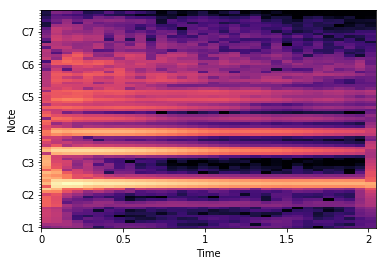

In [137]:
librosa.display.specshow(librosa.amplitude_to_db(cqt, ref=np.max),
                         sr=8000, x_axis='time', y_axis='cqt_note')

In [142]:
(cqt_preds == y_val).mean()

0.788961038961039

In [163]:
cqt_preds = np.array(cqt_preds)

In [174]:
cqt_train = []
for row in tqdm(X_train[["x{}".format(i) for i in range(16000)]].values):
    cqt = librosa.core.cqt(row, 8000, n_bins=80)
    cqt_train.append(int(librosa.midi_to_note(librosa.amplitude_to_db(cqt, ref=np.max).mean(axis=1).argmax()+24)[-1]) - 3)

### Ensemble

In [144]:
all_predictions = pd.DataFrame({"SVM": svm_pred, "CQT": cqt_preds, "NN": predictions, "Catboost": preds_class})

In [169]:
final = []
for index, row in all_predictions.iterrows():
    votes = {x: 0 for x in row.unique()}
    for option in row.unique():
        if option == row["SVM"]:
            votes[option] += 0.5
        if option == row["CQT"]:
            votes[option] += 1
        if option == row["NN"]:
            votes[option] += 1
        if option == row["Catboost"]:
            votes[option] += 1
    final.append(max(votes, key=lambda key: votes[key]))
final = np.array(final)

In [170]:
(final == y_val).mean()

0.9090909090909091

(array([ 6.,  0.,  0.,  0.,  0., 13.,  0.,  0.,  0.,  9.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

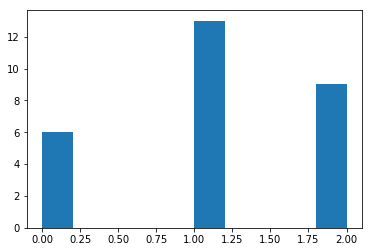

In [147]:
plt.hist(final[final != y_val])

(array([ 8.,  0.,  0.,  0.,  0., 12.,  0.,  0.,  0.,  8.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

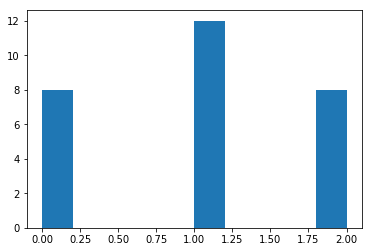

In [148]:
plt.hist(y_val[final != y_val])

In [149]:
for i,j in zip(final[final != y_val], y_val[final != y_val]):
    print(i,j)

2.0 1
1.0 0
0.0 2
1.0 0
1.0 2
2.0 1
2.0 1
2.0 0
1.0 0
1.0 2
0.0 1
1.0 2
1.0 0
2.0 1
0.0 1
0.0 1
1.0 2
1.0 0
2.0 1
1.0 2
2.0 0
2.0 1
1.0 0
1.0 2
2.0 1
1.0 2
0.0 1
0.0 1


In [160]:
cqt_misclass = cqt_preds != y_val

In [161]:
misclass = cat_misclass | svm_misclass | index_misclass | cqt_misclass

In [165]:
print("{:>8} {:>8} {:>8} {:>8} {:>8} {:>8}".format("Chroma","Catboost","NN","CQT","SVM","y_val"))
for i,j,k,l,m,n in zip(X_val[misclass]["Chroma"], preds_class[misclass], 
                   predictions[misclass], cqt_preds[misclass], svm_pred[misclass], y_val[misclass]):
    print("{:>8} {:>8} {:>8} {:>8} {:>8} {:>8}".format(i,j,k,l,m,n))

  Chroma Catboost       NN      CQT      SVM    y_val
       4      0.0        0       -1        0        0
       9      1.0        1        1        2        1
      11      0.0        0       -1        0        0
       5      2.0        1        2        1        1
       4      1.0        0        1        1        1
       4      2.0        2        1        2        2
       9      1.0        1        1        2        1
       6      1.0        1        0        1        1
       4      1.0        1        1        2        1
      10      1.0        0        1        2        0
       0      1.0        1        1        2        1
      11      1.0        0        0        2        0
       7      0.0        0       -1        2        0
       9      0.0        2        0        2        0
       0      2.0        2        1        2        2
      10      2.0        2        1        2        2
      10      0.0        0       -1        0        0
      11      0.0        0  

In [177]:
svm_train = clf.predict(X_train.drop("Chroma", axis=1))

In [178]:
NN_train = np.argmax(octave_model.predict(X_train.drop("Chroma", axis=1)), axis=1)

In [179]:
catboost_train = model.predict(train_dataset)

In [182]:
y_train

2225    2
2878    0
442     0
1075    1
2572    2
1365    2
2280    2
576     1
409     2
1647    2
1295    1
1883    0
370     1
648     0
988     1
2657    1
1584    2
1523    2
2629    2
580     0
2246    0
2963    0
1664    2
2744    1
1192    1
632     0
1178    1
64      2
336     1
470     0
       ..
569     0
125     1
2862    0
2983    0
626     0
533     0
678     0
963     1
188     1
2376    1
3080    1
354     0
2785    0
2782    2
434     0
3043    0
3164    1
2278    1
2690    1
2012    1
959     1
74      0
1562    2
587     0
1673    2
1897    0
864     0
2755    1
2288    2
527     0
Name: Octave, Length: 2842, dtype: int64

In [187]:
catboost_train.shape

(2842, 1)

In [203]:
catboost_train.reshape((2842,))

array([2., 0., 0., ..., 1., 2., 0.])

In [206]:
train_predictions = pd.DataFrame({"SVM": svm_train,
                                  "CQT": cqt_train, 
                                  "NN": NN_train, 
                                  "Catboost": catboost_train.reshape((2842,)), 
                                  "y_train": y_train})

In [211]:
logmodel = LogisticRegression(solver='lbfgs', multi_class='multinomial').fit(train_predictions.drop("y_train", axis=1), 
                                                                          train_predictions["y_train"])

In [212]:
logmodel.score(train_predictions.drop("y_train", axis=1), train_predictions["y_train"])

1.0

In [213]:
logmodel.score(all_predictions, y_val)

0.8993506493506493

In [214]:
vote_model = keras.Sequential([
    keras.layers.Dense(10, input_shape=(4,)),
    keras.layers.Dense(6, activation=tf.nn.relu),
    keras.layers.Dense(3, activation=tf.nn.softmax)
])
vote_model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [215]:
vote_model.fit(train_predictions.drop("y_train", axis=1), y_train, epochs=10, verbose=2)

Epoch 1/10
 - 0s - loss: 1.0531 - acc: 0.4085
Epoch 2/10
 - 0s - loss: 0.8025 - acc: 0.6795
Epoch 3/10
 - 0s - loss: 0.5976 - acc: 0.7702
Epoch 4/10
 - 0s - loss: 0.4002 - acc: 0.9015
Epoch 5/10
 - 0s - loss: 0.2625 - acc: 0.9944
Epoch 6/10
 - 0s - loss: 0.1730 - acc: 0.9944
Epoch 7/10
 - 0s - loss: 0.1137 - acc: 0.9947
Epoch 8/10
 - 0s - loss: 0.0756 - acc: 0.9958
Epoch 9/10
 - 0s - loss: 0.0518 - acc: 0.9989
Epoch 10/10
 - 0s - loss: 0.0367 - acc: 1.0000


In [216]:
val_loss, val_acc = vote_model.evaluate(all_predictions, y_val)
val_acc

308/308 [==============================] - ETA:  - 0s 205us/step


0.8993506501247357

In [44]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(data.drop(["Piano", "Note"], axis=1), "Octave")

In [45]:
chroma1_model = keras.Sequential([
    keras.layers.Dense(256, input_shape=(16000,)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(3, activation=tf.nn.softmax)
])
chroma1_model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [46]:
chroma1_model.fit(X_train[X_train["Chroma"] < 4].drop("Chroma", axis=1), y_train[X_train["Chroma"] < 4], epochs=10, verbose=2)

Epoch 1/10
 - 2s - loss: 0.8436 - acc: 0.6605
Epoch 2/10
 - 2s - loss: 0.4824 - acc: 0.8341
Epoch 3/10
 - 2s - loss: 0.3628 - acc: 0.9035
Epoch 4/10
 - 2s - loss: 0.2971 - acc: 0.9338
Epoch 5/10
 - 2s - loss: 0.2443 - acc: 0.9534
Epoch 6/10
 - 2s - loss: 0.2171 - acc: 0.9610
Epoch 7/10
 - 2s - loss: 0.1784 - acc: 0.9729
Epoch 8/10
 - 2s - loss: 0.1540 - acc: 0.9826
Epoch 9/10
 - 2s - loss: 0.1350 - acc: 0.9837
Epoch 10/10
 - 2s - loss: 0.1139 - acc: 0.9881


In [47]:
val_loss, val_acc = chroma1_model.evaluate(X_val[X_val["Chroma"] < 4].drop("Chroma", axis=1), y_val[X_val["Chroma"] < 4])
val_acc

90/90 [==============================] - ETA:  - 0s 1ms/step


0.8777777804268732

In [48]:
train_dataset = Pool(data=X_train[X_train["Chroma"] < 4].drop("Chroma", axis=1),
                     label=y_train[X_train["Chroma"] < 4])
eval_dataset = Pool(data=X_val[X_val["Chroma"] < 4].drop("Chroma", axis=1),
                    label=y_val[X_val["Chroma"] < 4])
model = CatBoostClassifier(iterations=1000, # 1000-2000
                           learning_rate=0.05, # 0.05
                           depth=8, # 8
                           loss_function='MultiClass', 
                           task_type="GPU")

In [49]:
model.fit(train_dataset)

0:	learn: -1.0782318	total: 797ms	remaining: 13m 15s
1:	learn: -1.0529453	total: 1.46s	remaining: 12m 6s
2:	learn: -1.0283759	total: 2.18s	remaining: 12m 3s
3:	learn: -1.0056996	total: 2.95s	remaining: 12m 13s
4:	learn: -0.9881254	total: 3.65s	remaining: 12m 5s
5:	learn: -0.9710125	total: 4.43s	remaining: 12m 14s
6:	learn: -0.9568709	total: 5.18s	remaining: 12m 14s
7:	learn: -0.9417715	total: 5.93s	remaining: 12m 15s
8:	learn: -0.9269320	total: 6.69s	remaining: 12m 16s
9:	learn: -0.9096072	total: 7.44s	remaining: 12m 16s
10:	learn: -0.8929343	total: 8.16s	remaining: 12m 13s
11:	learn: -0.8790913	total: 8.84s	remaining: 12m 8s
12:	learn: -0.8680456	total: 9.59s	remaining: 12m 8s
13:	learn: -0.8554821	total: 10.3s	remaining: 12m 8s
14:	learn: -0.8417349	total: 11.1s	remaining: 12m 10s
15:	learn: -0.8281639	total: 11.9s	remaining: 12m 12s
16:	learn: -0.8174048	total: 12.7s	remaining: 12m 11s
17:	learn: -0.8073553	total: 13.4s	remaining: 12m 10s
18:	learn: -0.7952337	total: 14.2s	remaining

151:	learn: -0.1879417	total: 2m 4s	remaining: 11m 34s
152:	learn: -0.1861813	total: 2m 5s	remaining: 11m 33s
153:	learn: -0.1845960	total: 2m 6s	remaining: 11m 32s
154:	learn: -0.1828005	total: 2m 6s	remaining: 11m 31s
155:	learn: -0.1811706	total: 2m 7s	remaining: 11m 31s
156:	learn: -0.1795785	total: 2m 8s	remaining: 11m 29s
157:	learn: -0.1780262	total: 2m 9s	remaining: 11m 29s
158:	learn: -0.1768173	total: 2m 10s	remaining: 11m 28s
159:	learn: -0.1758738	total: 2m 10s	remaining: 11m 27s
160:	learn: -0.1749950	total: 2m 11s	remaining: 11m 26s
161:	learn: -0.1737244	total: 2m 12s	remaining: 11m 25s
162:	learn: -0.1722929	total: 2m 13s	remaining: 11m 24s
163:	learn: -0.1707408	total: 2m 14s	remaining: 11m 23s
164:	learn: -0.1699486	total: 2m 14s	remaining: 11m 22s
165:	learn: -0.1685890	total: 2m 15s	remaining: 11m 20s
166:	learn: -0.1671896	total: 2m 16s	remaining: 11m 20s
167:	learn: -0.1658998	total: 2m 17s	remaining: 11m 19s
168:	learn: -0.1645928	total: 2m 18s	remaining: 11m 18s

299:	learn: -0.0752404	total: 4m 5s	remaining: 9m 31s
300:	learn: -0.0748711	total: 4m 5s	remaining: 9m 31s
301:	learn: -0.0746383	total: 4m 6s	remaining: 9m 29s
302:	learn: -0.0743958	total: 4m 7s	remaining: 9m 29s
303:	learn: -0.0741195	total: 4m 8s	remaining: 9m 28s
304:	learn: -0.0737479	total: 4m 9s	remaining: 9m 27s
305:	learn: -0.0733313	total: 4m 9s	remaining: 9m 26s
306:	learn: -0.0729222	total: 4m 10s	remaining: 9m 25s
307:	learn: -0.0726030	total: 4m 11s	remaining: 9m 24s
308:	learn: -0.0723011	total: 4m 12s	remaining: 9m 24s
309:	learn: -0.0718733	total: 4m 13s	remaining: 9m 23s
310:	learn: -0.0716028	total: 4m 13s	remaining: 9m 22s
311:	learn: -0.0712217	total: 4m 14s	remaining: 9m 21s
312:	learn: -0.0709776	total: 4m 15s	remaining: 9m 20s
313:	learn: -0.0707183	total: 4m 16s	remaining: 9m 19s
314:	learn: -0.0704200	total: 4m 17s	remaining: 9m 19s
315:	learn: -0.0701125	total: 4m 17s	remaining: 9m 17s
316:	learn: -0.0697702	total: 4m 18s	remaining: 9m 16s
317:	learn: -0.06

450:	learn: -0.0425482	total: 6m 4s	remaining: 7m 23s
451:	learn: -0.0424217	total: 6m 4s	remaining: 7m 22s
452:	learn: -0.0422581	total: 6m 5s	remaining: 7m 21s
453:	learn: -0.0421223	total: 6m 6s	remaining: 7m 20s
454:	learn: -0.0420021	total: 6m 7s	remaining: 7m 20s
455:	learn: -0.0418274	total: 6m 8s	remaining: 7m 19s
456:	learn: -0.0416691	total: 6m 9s	remaining: 7m 18s
457:	learn: -0.0415512	total: 6m 9s	remaining: 7m 17s
458:	learn: -0.0414658	total: 6m 10s	remaining: 7m 16s
459:	learn: -0.0413804	total: 6m 11s	remaining: 7m 16s
460:	learn: -0.0412636	total: 6m 12s	remaining: 7m 15s
461:	learn: -0.0411045	total: 6m 12s	remaining: 7m 14s
462:	learn: -0.0409441	total: 6m 13s	remaining: 7m 13s
463:	learn: -0.0408491	total: 6m 14s	remaining: 7m 12s
464:	learn: -0.0407674	total: 6m 15s	remaining: 7m 11s
465:	learn: -0.0406026	total: 6m 15s	remaining: 7m 10s
466:	learn: -0.0405419	total: 6m 16s	remaining: 7m 9s
467:	learn: -0.0404456	total: 6m 17s	remaining: 7m 9s
468:	learn: -0.04032

600:	learn: -0.0284034	total: 7m 59s	remaining: 5m 18s
601:	learn: -0.0283519	total: 7m 59s	remaining: 5m 17s
602:	learn: -0.0283022	total: 8m	remaining: 5m 16s
603:	learn: -0.0282173	total: 8m 1s	remaining: 5m 15s
604:	learn: -0.0281546	total: 8m 2s	remaining: 5m 14s
605:	learn: -0.0281118	total: 8m 2s	remaining: 5m 13s
606:	learn: -0.0280552	total: 8m 3s	remaining: 5m 13s
607:	learn: -0.0279673	total: 8m 4s	remaining: 5m 12s
608:	learn: -0.0278967	total: 8m 4s	remaining: 5m 11s
609:	learn: -0.0278475	total: 8m 5s	remaining: 5m 10s
610:	learn: -0.0277319	total: 8m 6s	remaining: 5m 9s
611:	learn: -0.0276476	total: 8m 7s	remaining: 5m 8s
612:	learn: -0.0275951	total: 8m 7s	remaining: 5m 7s
613:	learn: -0.0275290	total: 8m 8s	remaining: 5m 7s
614:	learn: -0.0274816	total: 8m 9s	remaining: 5m 6s
615:	learn: -0.0273720	total: 8m 9s	remaining: 5m 5s
616:	learn: -0.0272922	total: 8m 10s	remaining: 5m 4s
617:	learn: -0.0272271	total: 8m 11s	remaining: 5m 3s
618:	learn: -0.0271797	total: 8m 12

751:	learn: -0.0207603	total: 9m 52s	remaining: 3m 15s
752:	learn: -0.0207309	total: 9m 53s	remaining: 3m 14s
753:	learn: -0.0207065	total: 9m 54s	remaining: 3m 13s
754:	learn: -0.0206704	total: 9m 54s	remaining: 3m 12s
755:	learn: -0.0206418	total: 9m 55s	remaining: 3m 12s
756:	learn: -0.0206168	total: 9m 56s	remaining: 3m 11s
757:	learn: -0.0205796	total: 9m 56s	remaining: 3m 10s
758:	learn: -0.0205185	total: 9m 57s	remaining: 3m 9s
759:	learn: -0.0204861	total: 9m 58s	remaining: 3m 8s
760:	learn: -0.0204415	total: 9m 59s	remaining: 3m 8s
761:	learn: -0.0203835	total: 9m 59s	remaining: 3m 7s
762:	learn: -0.0203613	total: 10m	remaining: 3m 6s
763:	learn: -0.0203310	total: 10m 1s	remaining: 3m 5s
764:	learn: -0.0202976	total: 10m 2s	remaining: 3m 5s
765:	learn: -0.0202614	total: 10m 3s	remaining: 3m 4s
766:	learn: -0.0202360	total: 10m 3s	remaining: 3m 3s
767:	learn: -0.0202102	total: 10m 4s	remaining: 3m 2s
768:	learn: -0.0201750	total: 10m 5s	remaining: 3m 1s
769:	learn: -0.0201389	t

899:	learn: -0.0163003	total: 11m 42s	remaining: 1m 18s
900:	learn: -0.0162815	total: 11m 43s	remaining: 1m 17s
901:	learn: -0.0162642	total: 11m 44s	remaining: 1m 16s
902:	learn: -0.0162267	total: 11m 44s	remaining: 1m 15s
903:	learn: -0.0162022	total: 11m 45s	remaining: 1m 14s
904:	learn: -0.0161563	total: 11m 46s	remaining: 1m 14s
905:	learn: -0.0161376	total: 11m 46s	remaining: 1m 13s
906:	learn: -0.0161142	total: 11m 47s	remaining: 1m 12s
907:	learn: -0.0160962	total: 11m 48s	remaining: 1m 11s
908:	learn: -0.0160821	total: 11m 49s	remaining: 1m 10s
909:	learn: -0.0160500	total: 11m 49s	remaining: 1m 10s
910:	learn: -0.0160335	total: 11m 50s	remaining: 1m 9s
911:	learn: -0.0160069	total: 11m 51s	remaining: 1m 8s
912:	learn: -0.0159754	total: 11m 52s	remaining: 1m 7s
913:	learn: -0.0159547	total: 11m 52s	remaining: 1m 7s
914:	learn: -0.0159332	total: 11m 53s	remaining: 1m 6s
915:	learn: -0.0159132	total: 11m 54s	remaining: 1m 5s
916:	learn: -0.0158833	total: 11m 55s	remaining: 1m 4s

In [50]:
preds_class = model.predict(eval_dataset)
preds_class = preds_class.reshape((preds_class.shape[0],))

In [51]:
(preds_class == y_val[X_val["Chroma"] < 4]).mean()

0.9222222222222223